In [169]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [170]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    """
    Genera una figura con las franjas donde 'func' toma los valores 
    [0, 0.25, 0.5, 0.75, 1], pintando cada franja de un color, desde
    el rojo (0) hasta el azul (1)

    Argumentos:
    func -- función que recibe una fila de X y devuelve un valor 
    entre 0 y 1
    X -- datos sobre los que se calcula la función 'func'
    y -- etiquetas de los datos X

    Ejemplo:
    plot_decision_boundary(lambda x: model.predict(x), X, y)
    """

    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)


def plot_multiclass_decision_boundary(model, X, y):
    """
    Genera una figura con las fronteras de decisión de un modelo 
    de Keras

    Argumentos:
    model -- modelo de Keras
    X, y -- datos y etiquetas
    """

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    

def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()


def plot_loss_accuracy(history):
    """
    Genera una figura con la evolución del coste y la precisión durante
    el entrenamiento de un modelo en Keras. 

    Argumentos:
    history -- un objeto History devuelto por el método fit de Keras
    https://keras.io/models/model/#fit
    """

    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))


def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    

def plot_confusion_matrix(model, X, y):
    """
    Genera una figura con un mapa de calor que representa la matriz
    de confusión del modelo 'model' aplicado sobre los datos X comparado
    con las etiquetas de y

    Argumentos:
    model -- modelo de Keras
    X, y -- datos y etiquetas
    """

    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d',
                cmap='YlGnBu', alpha=0.8, vmin=0)


def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    

def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y


def make_multiclass(N=500, D=2, K=3, print=False):
    """
    Genera datos aleatorios donde cada clase se distribuye sobre
    una rama helicoidal que parte del origen de coordenadas

    N -- número de puntos por clase
    D -- número de dimensiones de cada dato 
    K -- número de clases
    """

    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    if print:
        fig = plt.figure(figsize=(6, 6))
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
        plt.xlim([-1,1])
        plt.ylim([-1,1])
        plt.savefig('img/multiclass.pdf')
    return X, y

In [171]:
def plot_relevant_info(X, y):
  #model.summary()
  history = model.fit(x=X, y=y, verbose=0, epochs=40)

  ## Print report
  y_pred = model.predict_classes(X, verbose=0)
  print(classification_report(y, y_pred))

  ## Print accuracy loss
  plot_loss_accuracy(history)

  ## Matrix and decision boundary
  plot_decision_boundary(lambda x: model.predict(x), X, y)
  plot_confusion_matrix(model, X, y)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.50      0.50      0.50       500
           1       0.50      0.51      0.51       500

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


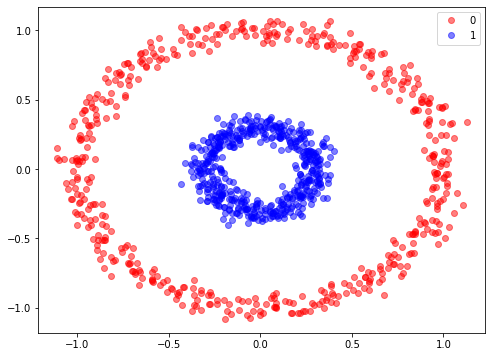

<Figure size 576x432 with 0 Axes>

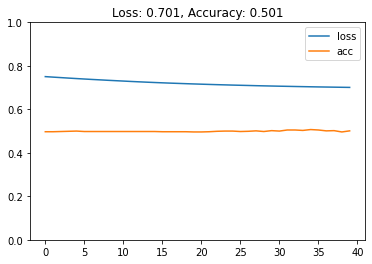

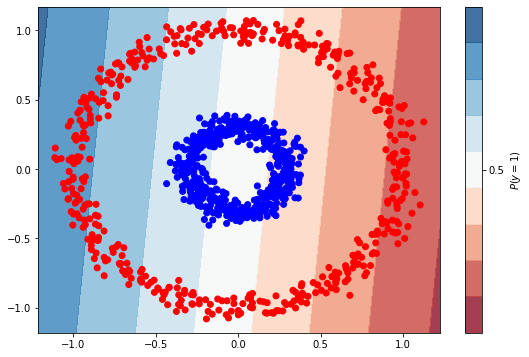

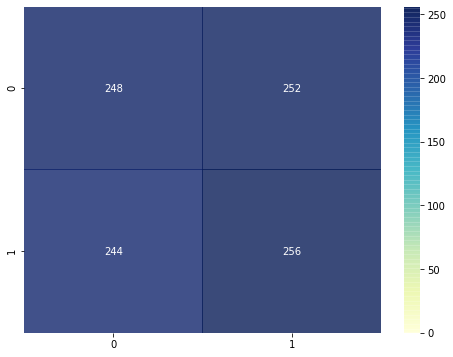

In [172]:
# 1.1 Circles
X, y = make_circles(n_samples=1000, noise =0.05 , factor =0.3 , random_state=0)
plot_data(X,y)

model = Sequential() 
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

plot_relevant_info(X, y)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.85      0.79      0.82       500
           1       0.80      0.86      0.83       500

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


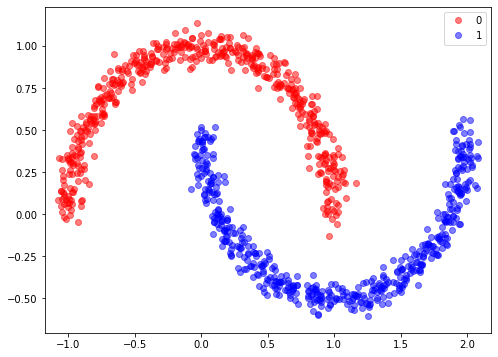

<Figure size 576x432 with 0 Axes>

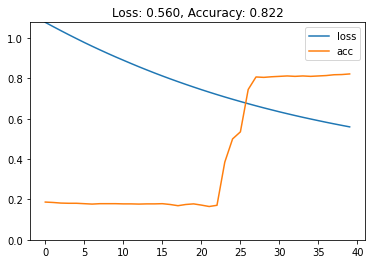

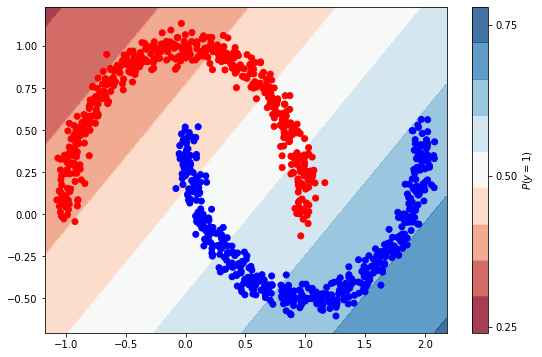

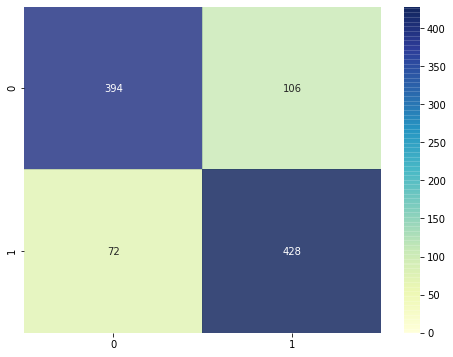

In [173]:
# 1.1 Moons
X, y = make_moons(n_samples=1000, noise =0.05 , random_state=0)
plot_data(X,y)

model = Sequential() 
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

plot_relevant_info(X, y)

In [174]:
def plot_relevant_info_network(X_train, X_test, y_train, y_test):
  #model.summary()
  history = model.fit(x=X_train, y=y_train, verbose=0, epochs=20)
  y_pred = model.predict_classes(X_test, verbose=0)

  ## Print report
  y_pred = model.predict_classes(X_test, verbose=0)
  print(classification_report(y_test, y_pred))

  ## Print accuracy loss
  plot_loss_accuracy(history)

  ## Matrix
  plot_confusion_matrix(model, X_test, y_test)

In [175]:
## Reconocimiento de numeros
# Carga de datos del fichero ex4data1.mat
data = loadmat('/content/ex4data1.mat')
X = data['X']
y = data['y']  

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.33, stratify=y)
y_train_one_hot = tf.keras.utils.to_categorical(y_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           1       0.98      0.96      0.97       165
           2       0.94      0.91      0.92       165
           3       0.90      0.90      0.90       165
           4       0.92      0.92      0.92       165
           5       0.94      0.83      0.88       165
           6       0.94      0.99      0.96       165
           7       0.93      0.94      0.93       165
           8       0.91      0.92      0.91       165
           9       0.91      0.91      0.91       165
          10       0.90      0.99      0.95       165

    accuracy                           0.93      1650
   macro avg       0.93      0.93      0.93      1650
weighted avg       0.93      0.93      0.93      1650



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 576x432 with 0 Axes>

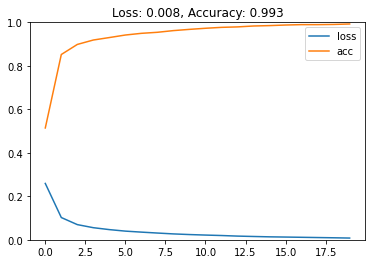

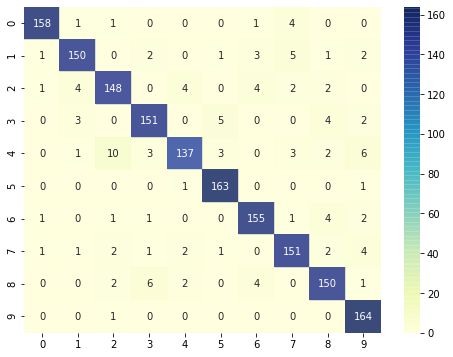

In [176]:
# First neuronal network - 2 layers - relu
model = Sequential() 
model.add(Dense(units=64, input_shape=(400,), activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=11, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
plot_relevant_info_network(X_train, X_test, y_train_one_hot, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           1       0.98      0.96      0.97       165
           2       0.92      0.92      0.92       165
           3       0.93      0.89      0.91       165
           4       0.90      0.92      0.91       165
           5       0.92      0.87      0.89       165
           6       0.95      0.97      0.96       165
           7       0.93      0.92      0.92       165
           8       0.89      0.92      0.90       165
           9       0.88      0.90      0.89       165
          10       0.95      0.98      0.96       165

    accuracy                           0.92      1650
   macro avg       0.92      0.92      0.92      1650
weighted avg       0.92      0.92      0.92      1650



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 576x432 with 0 Axes>

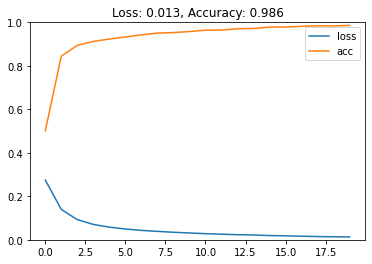

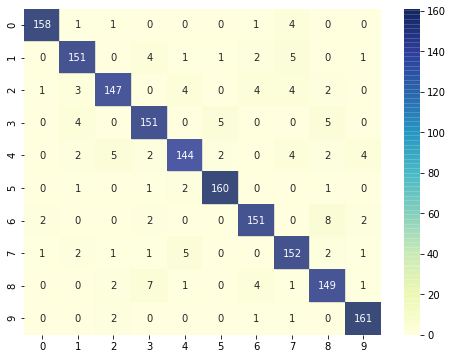

In [177]:
# Second neuronal network - 2 layers - tanh
model = Sequential() 
model.add(Dense(units=64, input_shape=(400,), activation='tanh'))
model.add(Dense(units=64, activation='tanh'))
model.add(Dense(units=11, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
plot_relevant_info_network(X_train, X_test, y_train_one_hot, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           1       0.99      0.94      0.97       165
           2       0.92      0.88      0.90       165
           3       0.95      0.87      0.91       165
           4       0.91      0.90      0.91       165
           5       0.91      0.90      0.90       165
           6       0.92      0.99      0.95       165
           7       0.91      0.91      0.91       165
           8       0.84      0.92      0.88       165
           9       0.89      0.92      0.90       165
          10       0.94      0.96      0.95       165

    accuracy                           0.92      1650
   macro avg       0.92      0.92      0.92      1650
weighted avg       0.92      0.92      0.92      1650



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 576x432 with 0 Axes>

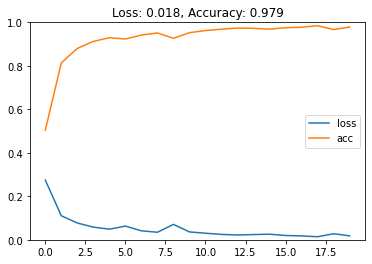

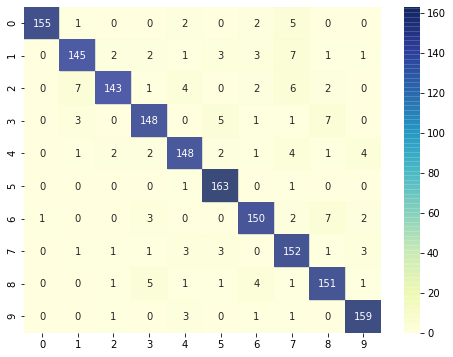

In [178]:
# Third neuronal network - 2 layers - exponential
model = Sequential() 
model.add(Dense(units=64, input_shape=(400,), activation='exponential'))
model.add(Dense(units=64, activation='exponential'))
model.add(Dense(units=11, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
plot_relevant_info_network(X_train, X_test, y_train_one_hot, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           1       0.98      0.95      0.97       165
           2       0.93      0.92      0.92       165
           3       0.92      0.91      0.91       165
           4       0.93      0.90      0.92       165
           5       0.94      0.89      0.91       165
           6       0.94      0.99      0.96       165
           7       0.92      0.94      0.93       165
           8       0.90      0.89      0.89       165
           9       0.90      0.90      0.90       165
          10       0.91      0.98      0.94       165

    accuracy                           0.93      1650
   macro avg       0.93      0.93      0.93      1650
weighted avg       0.93      0.93      0.93      1650



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 576x432 with 0 Axes>

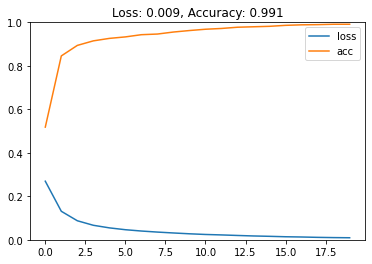

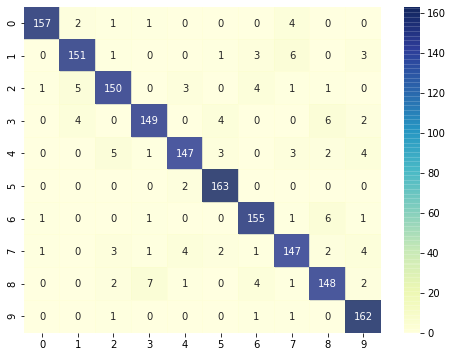

In [179]:
# Forth neuronal network - 2 layers best combined
model = Sequential() 
model.add(Dense(units=64, input_shape=(400,), activation='relu'))
model.add(Dense(units=64, activation='tanh'))
model.add(Dense(units=11, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
plot_relevant_info_network(X_train, X_test, y_train_one_hot, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           1       0.98      0.95      0.96       165
           2       0.92      0.92      0.92       165
           3       0.92      0.93      0.92       165
           4       0.94      0.92      0.93       165
           5       0.94      0.92      0.93       165
           6       0.95      0.99      0.97       165
           7       0.92      0.93      0.92       165
           8       0.93      0.92      0.92       165
           9       0.92      0.93      0.92       165
          10       0.96      0.98      0.97       165

    accuracy                           0.94      1650
   macro avg       0.94      0.94      0.94      1650
weighted avg       0.94      0.94      0.94      1650



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 576x432 with 0 Axes>

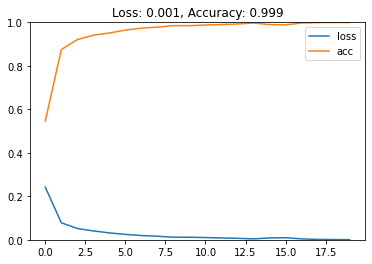

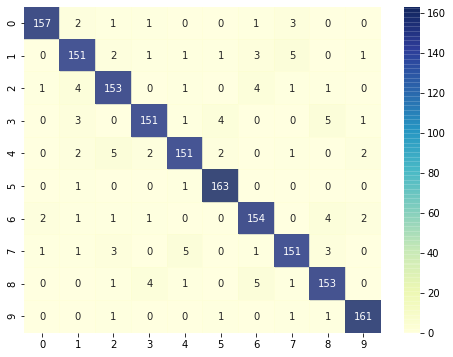

In [180]:
# Fifth neuronal network - 3 layers all combined
model = Sequential() 
model.add(Dense(units=64, input_shape=(400,), activation='relu'))
model.add(Dense(units=64, activation='tanh'))
model.add(Dense(units=64, activation='exponential'))
model.add(Dense(units=11, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
plot_relevant_info_network(X_train, X_test, y_train_one_hot, y_test)